In [737]:
import torch
import numpy as np

### Using tensors
Creating a tensor from a list

In [738]:
data = [[1,2],[3,4]]
x_data = torch.tensor(data)
print(x_data)
print(type(x_data))

tensor([[1, 2],
        [3, 4]])
<class 'torch.Tensor'>


Creating a tensor from a numpy array

In [739]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
print("Numpy Array:\n", np_array,"\nTorch tensor:\n", x_np)
print(type(x_np))

Numpy Array:
 [[1 2]
 [3 4]] 
Torch tensor:
 tensor([[1, 2],
        [3, 4]])
<class 'torch.Tensor'>


### Datasets and Dataloaders

In [740]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [741]:
# Loading the training and test data
training_data = datasets.MNIST(
    root="MNISTset",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="MNISTset",
    train=False,
    download=True,
    transform=ToTensor()
)

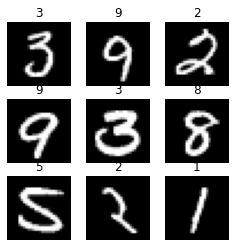

In [742]:
# Visualizing the data
figure = plt.figure(figsize = (4,4))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = np.random.randint(len(training_data))
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [743]:
# Using dataloaders to break up the data into minibatches
from torch.utils.data import DataLoader
batchSize = 32
training_dl = DataLoader(training_data, batch_size=batchSize, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batchSize, shuffle=True)
x_train, y_train = next(iter(training_dl))

In [744]:
print("Number of mini-batches: ", len(test_dl))
# for batchNum, (X,y) in enumerate(test_dl):
#     print("Minibatch #: ", batchNum, "Input shape: ", X.shape, "Number of labels: ", len(y), "First label: ", y[0])

Number of mini-batches:  313


Mini-batch labels:  [6, 4, 1, 0, 4, 0, 8, 9, 8, 1, 8, 4, 8, 7, 2, 1, 1, 2, 4, 8, 8, 4, 2, 8, 1, 2, 1, 2, 7, 1, 9, 6]


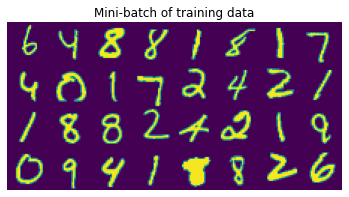

In [745]:
# Visualize a mini batch on a 8x4 grid (when batch size is 32)
plt.axis("off"), plt.title("Mini-batch of training data")
plt.imshow(torch.cat([y for y in x_train.squeeze().reshape([8,28*4,28])], 1))
print("Mini-batch labels: ", [label.item() for label in y_train])

### Building the Neural Network

In [746]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using {} device".format(device))
from torch import nn

Using cpu device


In [747]:
# creating thee Network class
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.flatten(x)
        y = self.linear_relu_stack(x)
#         print("Size of fwd pass output: ", y.argmax(dim=1).shape, "Output of fwd pass: ", y.argmax(dim=1))
        return y#.argmax(dim=1)

In [748]:
model = ANN().to(device)
# print(model)

Predicted label:  tensor([[0.5092, 0.4550, 0.6057, 0.5482, 0.5884, 0.4199, 0.4597, 0.4484, 0.5344,
         0.5195]], grad_fn=<SigmoidBackward>)


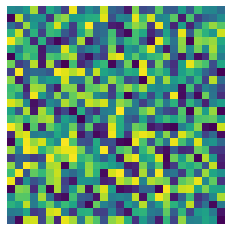

In [749]:
X = torch.rand(1,28,28, device=device)
# X = x_train[0]
plt.axis("off"), plt.imshow(X.reshape(28,28))
yy = nn.Flatten(X)
pred = model(X)
print("Predicted label: ", pred)

In [750]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  ANN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=10, bias=True)
    (5): Sigmoid()
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([16, 784]) | Values : tensor([[-0.0103, -0.0305,  0.0084,  ..., -0.0318, -0.0326,  0.0011],
        [ 0.0355,  0.0210, -0.0159,  ...,  0.0092,  0.0268, -0.0344]],
       grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([16]) | Values : tensor([-0.0223, -0.0060], grad_fn=<SliceBackward>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([16, 16]) | Values : tensor([[ 0.1172, -0.1089,  0.1860,  0.0632, -0.1166,  0.0650, -0.1002, -0.0298,
         -0.1963, -0.1664, -0.1788, -0.2062, -0.0202, -0.1238,  0.0661, -0.2217],
        [ 0.0767, -0.0375, -0.0991,  0.2

### Training the network

In [751]:
# Defining a loss function
# using the MSE loss function
loss_fn = nn.MSELoss()
#using the cross-entropy loss function
# loss_fn = nn.CrossEntropyLoss()

# Defining the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Training Loop

(For one epoch)

In [752]:
def training_loop(dataloader, model, loss_fn, optimizer):
    # get the total number of training examples
    size = len(dataloader.dataset)
    
    # forward pass
    # for each mini-batch, take the batch #, the input data, and label
    for batchNum, (X,y) in enumerate(dataloader):
        # compute the prediction and the loss
        pred = model(X)
        print("Prediction: ", pred.shape, ":: ", pred)
        print("Label from data: ", y.shape, ":: ", y)
        loss = loss_fn(pred, y)
        
        # backward pass
        optimizer.zero_grad()  # zero out the gradients
        loss.backward()        # perform backprop to get the gradients
        optimizer.step()       # update the parameters of the network
    
        # print progress
        if batchNum % 100 == 0: # print out progress every 100 mini-batches
            loss, current = loss.item(), batchNum * len(X)
            print("Loss: ", loss, "| ", current,"/", size)

#### Test/Validation Loop

(for one epoch)

In [753]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    # turn of autodiff
    with torch.no_grad():
        # for each mini-batch, take the input data and the label
        for (X,y) in enumerate(dataloader):
            pred = model(X)                        # compute the network's prediction
            test_loss += loss_fn(pred, y).item()   # compute the loss for each test example
            # maintain a running sum of number of correct predictions
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("Test error:\nAccuracy: ", 100 * correct,"% , Avg. loss: ", test_loss)

### Training and Validation (full network)

Setting up the hyper-parameters

In [754]:
learning_rate = 0.001
batch_size = 32
num_epochs = 5

# resetting the data loaders
training_dl = DataLoader(training_data, batch_size=batchSize, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batchSize, shuffle=True)

In [755]:
# training loop
for epoch in range(num_epochs):
    print("Epoch # ", epoch, "\n------------------------------")
    training_loop(training_dl, model, loss_fn, optimizer)
    test_loop(test_dl, model, loss_fn)
print("Done!")

Epoch #  0 
------------------------------
Prediction:  torch.Size([32, 10]) ::  tensor([[0.5082, 0.4535, 0.6059, 0.5493, 0.5870, 0.4182, 0.4600, 0.4473, 0.5330,
         0.5193],
        [0.5087, 0.4545, 0.6064, 0.5493, 0.5861, 0.4183, 0.4607, 0.4482, 0.5333,
         0.5182],
        [0.5082, 0.4553, 0.6049, 0.5492, 0.5869, 0.4200, 0.4603, 0.4493, 0.5330,
         0.5193],
        [0.5091, 0.4554, 0.6046, 0.5493, 0.5877, 0.4190, 0.4603, 0.4489, 0.5341,
         0.5185],
        [0.5084, 0.4549, 0.6052, 0.5494, 0.5861, 0.4181, 0.4601, 0.4479, 0.5331,
         0.5180],
        [0.5084, 0.4547, 0.6051, 0.5489, 0.5861, 0.4191, 0.4595, 0.4487, 0.5321,
         0.5187],
        [0.5086, 0.4545, 0.6060, 0.5488, 0.5871, 0.4193, 0.4599, 0.4477, 0.5331,
         0.5195],
        [0.5086, 0.4539, 0.6049, 0.5497, 0.5870, 0.4184, 0.4605, 0.4488, 0.5332,
         0.5185],
        [0.5094, 0.4541, 0.6060, 0.5501, 0.5861, 0.4186, 0.4610, 0.4488, 0.5318,
         0.5185],
        [0.5091, 0.4544, 0.6

/home/vibhav/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 1

In [ ]:
x_train, y_train = next(iter(training_dl))

In [756]:
pred = model(x_train)
yy = torch.tensor(pred, dtype=torch.short)
yyt = torch.tensor(y_train, dtype=torch.short)
loss_fn(pred, y_train)


/tmp/ipykernel_31580/2182512282.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(pred, dtype=torch.short)
/tmp/ipykernel_31580/2182512282.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yyt = torch.tensor(y_train, dtype=torch.short)


RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 1